In [1]:
#check whether cuda is enabled or not
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA L4
Using device: cuda


In [2]:
from huggingface_hub import notebook_login

In [3]:
from datasets import load_dataset #65
from evaluate import load #55

In [4]:
import wandb
import pandas as pd
import numpy as np
import re
import json
from sklearn.model_selection import train_test_split
import random
from IPython.display import display, HTML
import torchaudio 

In [5]:
wandb.login(key="17e571ce732c38896183d4d8756eee3ceb5ec0fd") # add wandb API key

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /teamspace/studios/this_studio/.netrc
wandb: Currently logged in as: shresthpiyusha (shresthpiyusha-khwopa-engineering-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
wandb.init(project="lipyantrak")

In [7]:
!mkdir csv_files
!mkdir trained_models
!mkdir checkpoints
!mkdir tokenizer 
!mkdir processor 
!mkdir feature_extractor

mkdir: cannot create directory ‘csv_files’: File exists


mkdir: cannot create directory ‘trained_models’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘tokenizer’: File exists
mkdir: cannot create directory ‘processor’: File exists


In [8]:
csv_folder_path = './csv_files'
trained_model_path ='./trained_models/wav2vec0.8dropout'
processor_path = './processor/wav2vec0.8dropout'
checkpoints_path = './checkpoints/'
tokenizer_path = './tokenizer/'
feature_extractor='./feature_extractor/'

In [9]:
colnames = ["path","labels"]
audio_path = './training_data/audio/'
transcript_path = './training_data/split_15.csv'
df = pd.read_csv(transcript_path,usecols=colnames)
df["path"] = audio_path + df["path"] + ".wav"
print(df.shape)
df.head()

(5000, 2)


,path,labels
0,./training_data/audio/f22b322d02.wav,रत्नलाल ब्राह्मन
1,./training_data/audio/a9551300e5.wav,उहाँले अभिनय गरेको
2,./training_data/audio/b66b8a664c.wav,बहुजातीय प्रजातन्त्रसम्म पुर्‍याए
3,./training_data/audio/99fa4290b2.wav,परम्पराका अनुसार
4,./training_data/audio/b50124946a.wav,नेपालको टिमलाई धन्यवाद


In [10]:
TEST_RATIO = 0.90 
VAL_RATIO = 0.75

In [11]:
train_df, test_df = train_test_split(df, random_state = 0, train_size = TEST_RATIO)
train_df, val_df = train_test_split(train_df, random_state = 0, train_size = VAL_RATIO)


In [12]:
train_df.to_csv(csv_folder_path+'/train.csv',index=False)
val_df.to_csv(csv_folder_path+'/val.csv',index=False)
test_df.to_csv(csv_folder_path+'/test.csv',index=False)

In [13]:
data_files = {
    "train": "train.csv",
    "validation": "val.csv",
    "test": "test.csv"
}

In [14]:
train_data = load_dataset(csv_folder_path, data_files = data_files, split = "train")
val_data = load_dataset(csv_folder_path, data_files = data_files, split = "validation")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [15]:
def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [16]:
# chars_to_ignore = '[\,\?\.\!\-\;\:\"\“\%\‘\”\ ]'
chars_to_ignore = r'[\,\?\.\!\-\;\:\"\“\%\‘\”\ ]'

In [17]:
def remove_special_characters(batch):
    batch["labels"] = re.sub(chars_to_ignore, '', batch["labels"]).lower() + " "
    return batch

In [18]:
train_data = train_data.map(remove_special_characters)
val_data = val_data.map(remove_special_characters)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/1125 [00:00<?, ? examples/s]

In [19]:
unique_letters = {
    "[PAD]": 0,
    "[UNK]": 1,
    "|": 2,
    " ": 3,  # Added space
    "क": 4,
    "ख": 5,
    "ग": 6,
    "घ": 7,
    "ङ": 8,
    "च": 9,
    "छ": 10,
    "ज": 11,
    "झ": 12,
    "ञ": 13,
    "ट": 14,
    "ठ": 15,
    "ड": 16,
    "ढ": 17,
    "ण": 18,
    "त": 19,
    "थ": 20,
    "द": 21,
    "ध": 22,
    "न": 23,
    "प": 24,
    "फ": 25,
    "ब": 26,
    "भ": 27,
    "म": 28,
    "य": 29,
    "र": 30,
    "ल": 31,
    "व": 32,
    "श": 33,
    "ष": 34,
    "स": 35,
    "ह": 36,
    "क्ष": 37,
    "त्र": 38,
    "ज्ञ": 39,
    "अ": 40,
    "आ": 41,
    "इ": 42,
    "ई": 43,
    "उ": 44,
    "ऊ": 45,
    "ए": 46,
    "ऐ": 47,
    "ओ": 48,
    "औ": 49,
    "अं": 50,
    "अः": 51,
    "ा": 52,
    "ि": 53,
    "ी": 54,
    "ु": 55,
    "ू": 56,
    "े": 57,
    "ै": 58,
    "ो": 59,
    "ौ": 60,
    "ं": 61,
    "ः": 62,
    "ँ": 63,
    "०": 64,
    "१": 65,
    "२": 66,
    "३": 67,
    "४": 68,
    "५": 69,
    "६": 70,
    "७": 71,
    "८": 72,
    "९": 73,
    "्": 74, # Halant (virama)
    "ऱ्": 75, 
    "ृ": 76
}


In [20]:
# Save to JSON format
output_file = "./input/cleaned-asr-data/data/vocabulary/vocab.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(unique_letters, f, ensure_ascii=False, indent=4)

print(f"Unique letters saved to {output_file}")

Unique letters saved to ./input/cleaned-asr-data/data/vocabulary/vocab.json


In [21]:
import os
from transformers import Trainer, TrainingArguments, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, AutoTokenizer

# Set environment variable to handle fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Define model and arguments
# model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53")

In [22]:
# model = Wav2Vec2ForCTC.from_pretrained(
#     "facebook/wav2vec2-large-xlsr-53", 
#     attention_dropout = 0.1,
#     hidden_dropout = 0.1,
#     feat_proj_dropout = 0.0,
#     mask_time_prob = 0.05,
#     layerdrop = 0.1,
#     gradient_checkpointing = True, 
#     ctc_loss_reduction = "mean", 
#     pad_token_id = processor.tokenizer.pad_token_id,
#     vocab_size = len(processor.tokenizer)
# )

# for checkpoint
# model = Wav2Vec2ForCTC.from_pretrained("./checkpoints/checkpoint-4500")

In [23]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Wav2Vec2ForCTC.from_pretrained("./checkpoints/checkpoint-900/")
model.gradient_checkpointing_enable()
model.config.attention_dropout = 0.3  # Increased dropout
model.config.hidden_dropout = 0.3
model.config.feat_proj_dropout = 0.2
model.config.mask_time_prob = 0.2
model.config.layerdrop = 0.25
model.to(device)

# Load processor
processor = Wav2Vec2Processor.from_pretrained("./processor/wav2vec0.8dropout/")

# Define optimizer and scheduler
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
decay_params, no_decay_params = [], []

for name, param in model.named_parameters():
    if any(nd in name for nd in no_decay):
        no_decay_params.append(param)
    else:
        decay_params.append(param)

# Print counts for reference (no need to match 149/247 or 149/275 exactly)
print(f"Number of parameters with decay: {len(decay_params)}")
print(f"Number of parameters without decay: {len(no_decay_params)}")
print(f"Total parameters: {len(decay_params) + len(no_decay_params)}")

Number of parameters with decay: 213
Number of parameters without decay: 211
Total parameters: 424


In [24]:
vocab_path = "./input/cleaned-asr-data/data/vocabulary/vocab.json"
tokenizer = Wav2Vec2CTCTokenizer(
    vocab_path, 
    unk_token = "[UNK]", 
    pad_token = "[PAD]", 
    word_delimiter_token = "|"
)

In [25]:
tokenizer.save_pretrained(tokenizer_path)

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.json',
 './tokenizer/added_tokens.json')

In [26]:
# feature_extractor = Wav2Vec2FeatureExtractor(
#     feature_size = 1, 
#     sampling_rate = 16000, 
#     padding_value = 0.0, 
#     do_normalize = True, 
#     return_attention_mask = True
# )

In [27]:
# processor = Wav2Vec2Processor(
#     feature_extractor = feature_extractor, 
#     tokenizer = tokenizer
# )

In [28]:
processor.save_pretrained(processor_path)
# tokenizer= AutoTokenizer.from_pretrained("your-model-name")
# tokenizer.save_pretrained("path/to/save/tokenizer")

[]

In [29]:
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = speech_array[0].numpy()
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["labels"]
    
    resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
    batch["speech"] = resampler(speech_array).squeeze().numpy()
    batch["sampling_rate"] = 16000
    
    return batch

In [ ]:
train_data = train_data.map(speech_file_to_array_fn, remove_columns=train_data.column_names)
val_data = val_data.map(speech_file_to_array_fn, remove_columns=val_data.column_names)

Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

In [54]:
from IPython.display import Audio  # Import the Audio class

In [55]:
rand_int = random.randint(0, len(train_data) - 1)

In [56]:
 train_data[rand_int]["target_text"]

'मन्दिरमाचढाएकोसामग्रीहरूबाट '

In [57]:
def prepare_dataset(batch, processor):
        
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate = batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [58]:
train_data = train_data.map(prepare_dataset, fn_kwargs = {"processor": processor}, remove_columns = train_data.column_names, batch_size = 8, num_proc = 4, batched = True)
val_data = val_data.map(prepare_dataset, fn_kwargs = {"processor": processor}, remove_columns = val_data.column_names, batch_size = 8, num_proc = 4, batched = True)

Map (num_proc=4):   0%|          | 0/3375 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers

Map (num_proc=4):   0%|          | 0/1125 [00:00<?, ? examples/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers

In [59]:
from dataclasses import dataclass
from typing import Any, Dict, List, Optional, Union

In [60]:
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [61]:
data_collator = DataCollatorCTCWithPadding(processor = processor, padding = True)

In [62]:
wer_metric = load("wer")
cer_metric = load("cer")

In [63]:
model.freeze_feature_encoder()

In [64]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
 
    # ✅ Log metrics to Weights & Biases
    wandb.log({'wer': wer, 'cer': cer})
    
    return {"wer": wer, "cer": cer}


In [65]:
from transformers import EarlyStoppingCallback
import accelerate

In [66]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    resume_from_checkpoint=True,
    per_device_train_batch_size=4,  # Increased batch size
    gradient_accumulation_steps=4,
    evaluation_strategy="steps",
    num_train_epochs=30,
    fp16=True,
    save_steps=300,
    eval_steps=300,
    logging_steps=100,
    learning_rate=1e-4,  # Slightly higher initial learning rate
    warmup_steps=500,    # Increased warmup steps
    save_total_limit=2,
    gradient_checkpointing=True,
    metric_for_best_model="wer",
    lr_scheduler_type="cosine",
    greater_is_better=False,
    report_to="wandb",
    weight_decay=0.1,          # Increased weight decay
    label_smoothing_factor=0.0,  # Added label smoothing
    max_grad_norm=1.0  # Gradient clipping
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [67]:
# Create a new optimizer from scratch
# optimizer = torch.optim.AdamW([
#     {"params": decay_params, "lr": training_args.learning_rate, "weight_decay": training_args.weight_decay},
#     {"params": no_decay_params, "lr": training_args.learning_rate, "weight_decay": 0.0}
# ])
optimizer = torch.optim.AdamW([
    {"params": decay_params, "lr": 1e-4, "weight_decay": 0.05},  # Lower LR
    {"params": no_decay_params, "lr": 1e-4, "weight_decay": 0.0}
])

# Adjusted scheduler (ReduceLROnPlateau)
total_steps = training_args.num_train_epochs * (len(train_data) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps))
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [68]:
import matplotlib.pyplot as plt


In [69]:
# Create the Trainer
trainer = Trainer(
    model=model,  # Your model
    data_collator=data_collator,  # Data collator for batching
    args=training_args,  # Training arguments
    compute_metrics=compute_metrics,  # Function to compute metrics
    train_dataset=train_data,  # Training dataset
    eval_dataset=val_data,  # Evaluation dataset
    tokenizer=processor.feature_extractor,  # Tokenizer/processor
    # processing_class=processor  # Use processing_class
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],  # Stop if no improvement for 5 epochs
    optimizers=(optimizer, scheduler)
)

/tmp/ipykernel_1873/1725020737.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [70]:
trainer.accelerator.scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_1873/2984383469.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  trainer.accelerator.scaler = torch.cuda.amp.GradScaler()


In [71]:
# trainer.train(resume_from_checkpoint="./checkpoints/checkpoint-600")
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer,Cer
300,0.733000,0.298184,0.600889,0.088314
600,0.709900,0.294055,0.588444,0.086275
900,0.650500,0.296227,0.571556,0.085728
1200,0.636100,0.310973,0.575111,0.084684
1500,0.609300,0.327442,0.607111,0.088961
1800,0.553600,0.328363,0.637333,0.094978
2100,0.555200,0.326870,0.613333,0.093536
2400,0.529200,0.340707,0.611556,0.091149


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers

TrainOutput(global_step=2400, training_loss=0.6269237422943115, metrics={'train_runtime': 2340.2746, 'train_samples_per_second': 43.264, 'train_steps_per_second': 2.705, 'total_flos': 6.792012708811892e+18, 'train_loss': 0.6269237422943115, 'epoch': 11.374407582938389})

In [72]:
trainer.save_model(trained_model_path)

In [73]:
#  Optionally, evaluate final model
final_metrics = trainer.evaluate()
print(f"Final WER: {final_metrics['eval_wer'] * 100:.2f}%")
print(f"Final CER: {final_metrics['eval_cer'] * 100:.2f}%")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Final WER: 61.16%
Final CER: 9.11%


In [74]:
# After training, compute final metrics
# metrics = trainer.evaluate()

In [75]:
# # Added: How to find loss, error, and accuracy
# print("\n==== Final Model Evaluation ====")
# print(f"Final WER (Word Error Rate): {metrics['eval_wer'] * 100:.2f}%")
# print(f"Final CER (Character Error Rate): {metrics['eval_cer'] * 100:.2f}%")
# print(f"Final Validation Loss: {metrics['eval_loss']:.4f}")

In [76]:
# # Added: Calculate Accuracy (1 - WER and 1 - CER)
# word_accuracy = (1 - metrics['eval_wer']) * 100
# char_accuracy = (1 - metrics['eval_cer']) * 100
# print(f"Word-Level Accuracy: {word_accuracy:.2f}%")
# print(f"Character-Level Accuracy: {char_accuracy:.2f}%")


In [77]:
# # Ensure loss visualization includes the final evaluation
# # Prepare data for plotting
# epochs = metrics_callback.epochs
# train_loss = metrics_callback.train_loss
# val_loss = metrics_callback.val_loss

In [78]:
# # Ensure lengths match for plotting
# min_length = min(len(epochs), len(train_loss), len(val_loss))
# epochs = epochs[:min_length]
# train_loss = train_loss[:min_length]
# val_loss = val_loss[:min_length]

In [79]:
# # Plot training and validation loss
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_loss, label="Training Loss", marker="o")
# plt.plot(epochs, val_loss, label="Validation Loss", marker="x")
# plt.title("Training and Validation Loss Over Epochs", fontsize=16)
# plt.xlabel("Epochs", fontsize=14)
# plt.ylabel("Loss", fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.show()

In [80]:
import matplotlib.pyplot as plt

# Extract logs from the trainer's log history
logs = trainer.state.log_history

# Extract values from logs
steps = [log["step"] for log in logs if "loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
wer = [log["eval_wer"] for log in logs if "eval_wer" in log]
cer = [log["eval_cer"] for log in logs if "eval_cer" in log]
learning_rate = [log["learning_rate"] for log in logs if "learning_rate" in log]


In [81]:
min_length = min(len(steps), len(eval_loss), len(wer), len(cer))
steps = steps[:min_length]
eval_loss = eval_loss[:min_length]
wer = wer[:min_length]
cer = cer[:min_length]
train_loss = train_loss[:min_length]
learning_rate = learning_rate[:min_length]

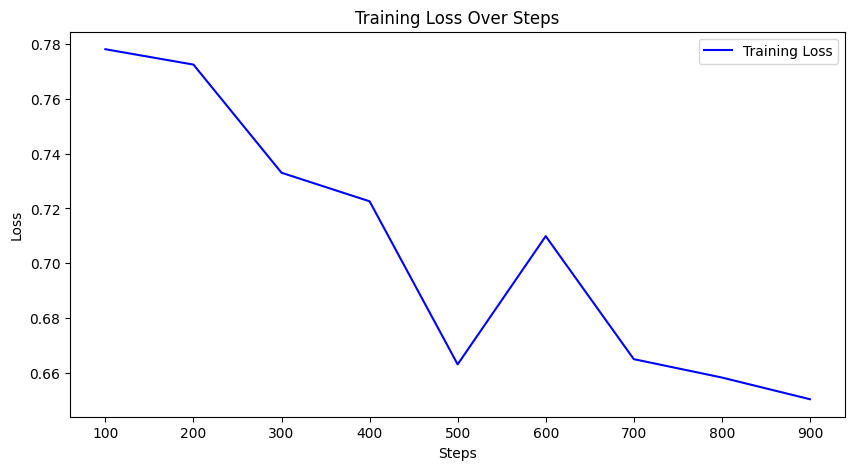

In [82]:
# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Training Loss", color="blue")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
plt.savefig("./graphs/split15/training_loss.png")
plt.show()


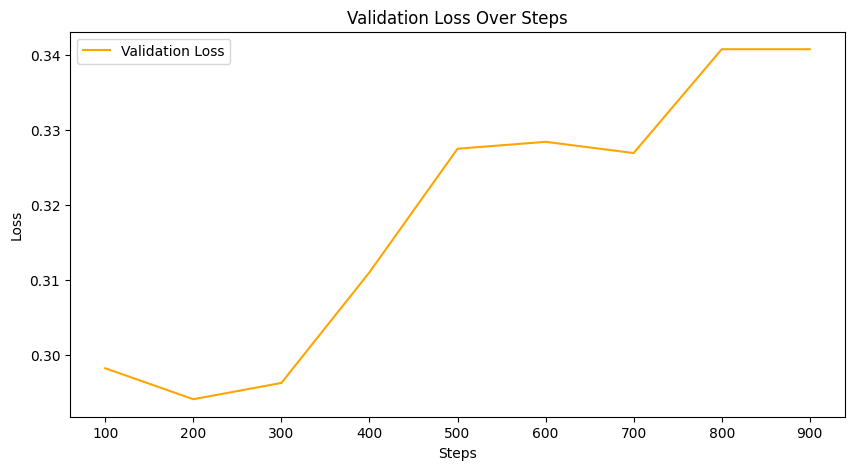

In [83]:
#save the plots # Plot Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(steps, eval_loss, label="Validation Loss", color="orange")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss Over Steps")
plt.legend()
plt.savefig("./graphs/split15/validation_loss.png")
plt.show()



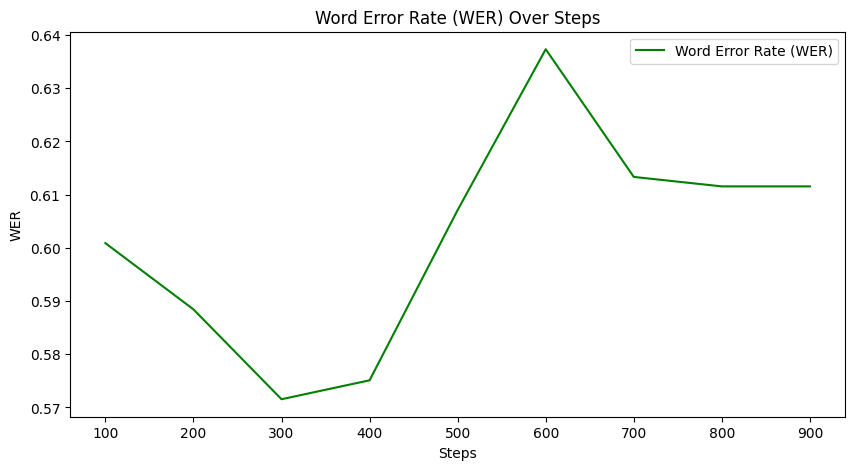

In [84]:
# Plot Word Error Rate (WER)
plt.figure(figsize=(10, 5))
plt.plot(steps, wer, label="Word Error Rate (WER)", color="green")
plt.xlabel("Steps")
plt.ylabel("WER")
plt.title("Word Error Rate (WER) Over Steps")
plt.legend()
plt.savefig("./graphs/split15/wer.png")
plt.show()



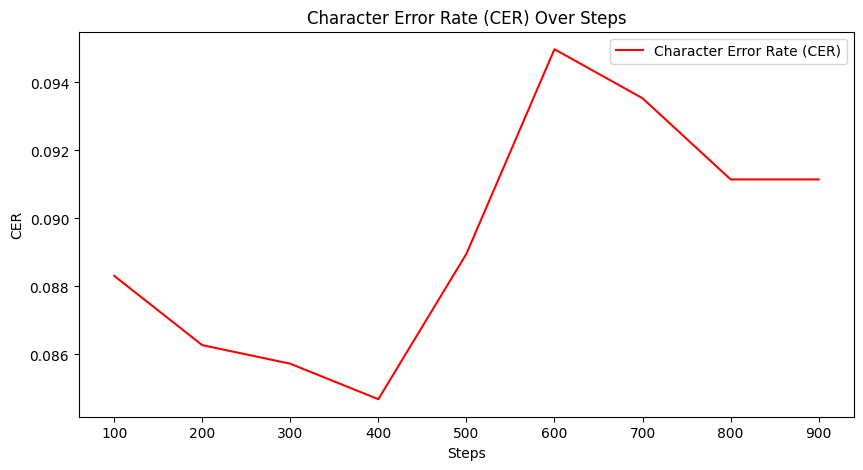

In [85]:
# Plot Character Error Rate (CER)
plt.figure(figsize=(10, 5))
plt.plot(steps, cer, label="Character Error Rate (CER)", color="red")
plt.xlabel("Steps")
plt.ylabel("CER")
plt.title("Character Error Rate (CER) Over Steps")
plt.legend()
plt.savefig("./graphs/split15/cer.png")
plt.show()



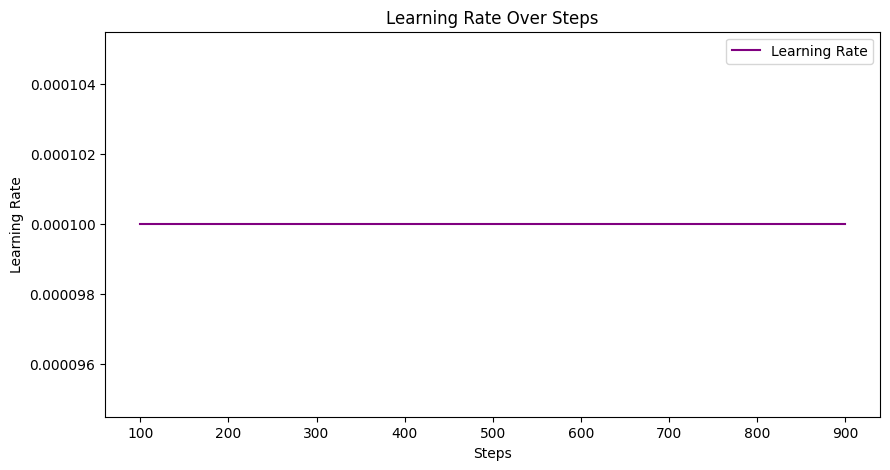

In [86]:
# Plot Learning Rate
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rate, label="Learning Rate", color="purple")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Over Steps")
plt.legend()
plt.savefig("./graphs/split15/learning_rate.png")
plt.show()